In [1]:
cd all

/home/user/Desktop/ACA/new/all


# The result was 0.34, not bad

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv', parse_dates=['timestamp'])

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [5]:
train.shape

(30471, 292)

In [53]:
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

# EDA and cleaning

## full_sq column

{'boxes': [<matplotlib.lines.Line2D at 0x7fcd31697a58>],
 'caps': [<matplotlib.lines.Line2D at 0x7fcd31622be0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd31630ac8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd31629c18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fcd31697c18>,
  <matplotlib.lines.Line2D at 0x7fcd31622a20>]}

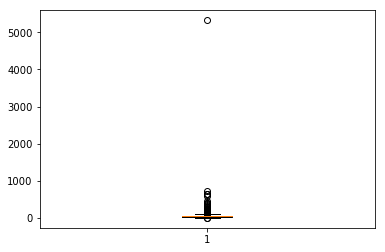

In [27]:
plt.boxplot(train['full_sq'])

In [4]:
train = train[train.full_sq < 5000]
train.loc[train.full_sq < 5, 'full_sq'] = np.NaN

In [5]:
train.loc[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3), "full_sq"] = np.NaN
test.loc[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3), "full_sq"] = np.NaN

## State

### There is  a 33 in 'state' column. Its obvious that its a mistake. Lets change it to most occuring value

In [6]:
print(train['state'].value_counts())
train.loc[train.state == 33, 'state'] = train['state'].mode()[0]

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64


/home/user/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


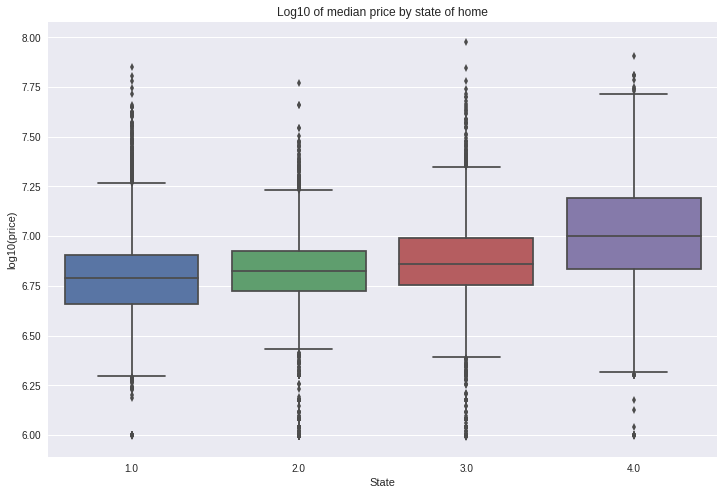

In [48]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train[train['state'].isnull()].index
sns.boxplot(x="state", y=np.log10(train['price_doc']), data=train.drop(ind))
ax.set(title='Log10 of median price by state of home', xlabel='State', ylabel='log10(price)')

## Build Year

In [7]:
# there are many houses with 0 or 1 as build year. 
# Maybe they are some specific types,
# Lets keep them but impute everything else with Na
print(train['build_year'][(train['build_year'] < 1500) |(train['build_year'] > 2017)].value_counts())
train.loc[((train['build_year'] > 1 ) & (train['build_year'] < 1500)) | (train['build_year'] > 2017),'build_year'] = np.NAN

0.0           530
1.0           368
3.0             2
20052009.0      1
4965.0          1
215.0           1
2018.0          1
71.0            1
20.0            1
Name: build_year, dtype: int64


In [8]:
print(test['build_year'][(test['build_year'] < 1500) | 
                      (test['build_year'] > 2017)].value_counts())
test.loc[((train['build_year'] > 1 ) & (train['build_year'] < 1500)) | (test['build_year'] > 2017),'build_year'] = np.NAN

0.0       369
1.0       187
2018.0     30
2019.0      5
215.0       1
2.0         1
Name: build_year, dtype: int64


## I found a useful way on kaggle to reduce the number of sub_areas.The number of initial classes of sub_areas is 146.  Sub_areas are mapped into larger districts and the number becomes 12

In [9]:
dists = {}
dists['Zelenograd'] = ["Krjukovo","Matushkino","Savelki","Silino","Staroe Krjukovo"]
dists['Novomoskovsky'] = ["Poselenie Desjonovskoe","Poselenie Filimonkovskoe","Poselenie Kokoshkino","Poselenie Marushkinskoe","Poselenie Moskovskij","Poselenie Mosrentgen","Poselenie Rjazanovskoe","Poselenie Shherbinka","Poselenie Sosenskoe","Poselenie Vnukovskoe","Poselenie Voskresenskoe"]
dists['Troitsky'] = ["Poselenie Kievskij","Poselenie Klenovskoe","Poselenie Krasnopahorskoe","Poselenie Mihajlovo-Jarcevskoe","Poselenie Novofedorovskoe","Poselenie Pervomajskoe","Poselenie Rogovskoe","Poselenie Shhapovskoe","Poselenie Voronovskoe","Troickij okrug"]
dists['Northern'] = ["Ajeroport","Begovoe","Beskudnikovskoe","Dmitrovskoe","Golovinskoe","Horoshevskoe","Hovrino","Koptevo","Levoberezhnoe","Molzhaninovskoe","Savelovskoe","Sokol","Timirjazevskoe","Vojkovskoe","Vostochnoe Degunino","Zapadnoe Degunino"]
dists['Southwest'] = ["Akademicheskoe","Cheremushki","Gagarinskoe","Jasenevo","Juzhnoe Butovo","Kon'kovo","Kotlovka","Lomonosovskoe","Obruchevskoe","Severnoe Butovo","Teplyj Stan","Zjuzino"]
dists['Northeast'] = ["Alekseevskoe","Altuf'evskoe","Babushkinskoe","Bibirevo","Butyrskoe","Jaroslavskoe","Juzhnoe Medvedkovo","Lianozovo","Losinoostrovskoe","Mar'ina Roshha","Marfino","Ostankinskoe","Otradnoe","Rostokino","Severnoe","Severnoe Medvedkovo","Sviblovo"]
dists['Central'] = ["Arbat","Basmannoe","Hamovniki","Jakimanka","Krasnosel'skoe","Meshhanskoe","Presnenskoe","Taganskoe","Tverskoe","Zamoskvorech'e"]
dists['Southern'] = ["Birjulevo Vostochnoe","Birjulevo Zapadnoe","Brateevo","Caricyno","Chertanovo Central'noe","Chertanovo Juzhnoe","Chertanovo Severnoe","Danilovskoe","Donskoe","Moskvorech'e-Saburovo","Nagatino-Sadovniki","Nagatinskij Zaton","Nagornoe","Orehovo-Borisovo Juzhnoe","Orehovo-Borisovo Severnoe","Zjablikovo"]
dists['Eastern'] = ["Bogorodskoe","Gol'janovo","Ivanovskoe","Izmajlovo","Kosino-Uhtomskoe","Metrogorodok","Novogireevo","Novokosino","Perovo","Preobrazhenskoe","Severnoe Izmajlovo","Sokol'niki","Sokolinaja Gora","Veshnjaki","Vostochnoe","Vostochnoe Izmajlovo"]
dists['Western'] = ["Dorogomilovo","Filevskij Park","Fili Davydkovo","Krylatskoe","Kuncevo","Mozhajskoe","Novo-Peredelkino","Ochakovo-Matveevskoe","Prospekt Vernadskogo","Ramenki","Solncevo","Troparevo-Nikulino","Vnukovo"]
dists['Northwest'] = ["Horoshevo-Mnevniki","Juzhnoe Tushino","Kurkino","Mitino","Pokrovskoe Streshnevo","Severnoe Tushino","Shhukino","Strogino"]
dists['Southeast'] = ["Juzhnoportovoe","Kapotnja","Kuz'minki","Lefortovo","Ljublino","Mar'ino","Nekrasovka","Nizhegorodskoe","Pechatniki","Rjazanskij","Tekstil'shhiki","Vyhino-Zhulebino"]

In [10]:
for i in dists:
    train.sub_area[train.sub_area.isin(dists[i])] = i
train.sub_area.value_counts()

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Novomoskovsky    6166
Southeast        3941
Southern         3217
Eastern          2916
Southwest        2441
Northern         2376
Northeast        2221
Western          2161
Northwest        2080
Central          1506
Zelenograd        926
Troitsky          519
Name: sub_area, dtype: int64

In [12]:
for i in dists:
    test.sub_area[test.sub_area.isin(dists[i])] = i

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Life square

In [14]:
train.loc[train['life_sq'] > train['full_sq'], 'life_sq'] = np.NAN
test.loc[test['life_sq'] > test['full_sq'], 'life_sq'] = np.NAN

In [15]:
train.loc[train['life_sq'] < 5, 'life_sq'] = np.NAN
test.loc[test['life_sq'] < 5, 'life_sq'] = np.NAN

## Room count

/home/user/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


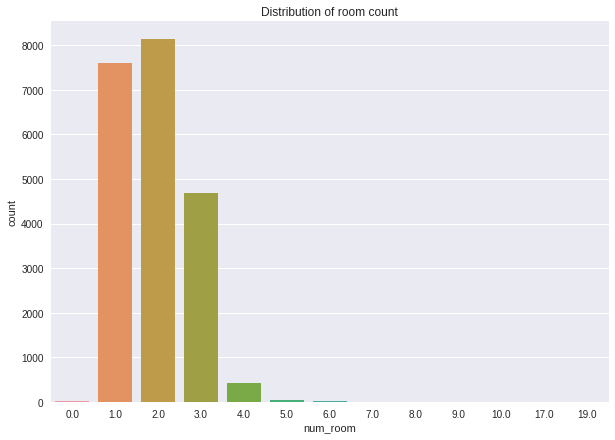

In [66]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x=train['num_room'])
ax.set(title='Distribution of room count', xlabel='num_room')

In [16]:
# full square is too little for so many rooms
train[(train.num_room > 6) & (train.full_sq < 100)]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
11621,11624,2013-10-28,40.0,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,...,1,1,0,2,11,0,0,6,0,2630000
17764,17767,2014-04-23,58.0,34.0,1.0,2.0,1.0,1992.0,10.0,10.0,...,0,0,0,0,2,0,2,8,1,6000000
26713,26716,2014-12-18,51.0,30.0,14.0,17.0,1.0,1984.0,17.0,8.0,...,41,4,1,6,37,1,7,84,10,13150000
29172,29175,2015-04-16,59.0,33.0,20.0,22.0,1.0,2000.0,10.0,10.0,...,5,1,0,9,24,0,3,51,8,11000000


In [17]:
train.loc[train.num_room == 0, 'num_room'] = np.NaN
train.loc[(train.num_room > 6) & (train.full_sq < 100), 'num_room'] = np.NaN

In [18]:
test.loc[test.num_room == 0, 'num_room'] = np.NaN
test.loc[(test.num_room > 6) & (test.full_sq < 100), 'num_room'] = np.NaN

## Floor and kitchen

In [19]:
train.loc[train.floor == 0, 'floor'] = np.NaN
test.loc[test.floor == 0, 'floor'] = np.NaN

In [20]:
train.loc[train.floor > train.max_floor, 'max_floor'] = np.NaN
test.loc[test.floor > test.max_floor, 'max_floor'] = np.NaN

In [21]:
train.loc[train.kitch_sq >= train.life_sq, 'kitch_sq'] = np.NAN
test.loc[test.kitch_sq >= test.life_sq, 'kitch_sq'] = np.NAN

## Remove very cheap and very expensive prices

In [22]:
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

# Some feature engineering

## Make month another feature, add month - year count and week-year counts

In [23]:
train['month'] = train.timestamp.dt.month
test['month'] = test.timestamp.dt.month

month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

## Relative kitchen, relative floor and room_size new features

In [24]:
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

## Encode the features

In [25]:
y_train = train["price_doc"]
id_train = train['id']
id_test = test['id']

x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

num_train = len(x_train)
x_all = pd.concat([x_train, x_test])

for c in x_all.columns:
    if x_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_all[c].values))
        x_all[c] = lbl.transform(list(x_all[c].values))
        
x_train = x_all[:num_train]
x_test = x_all[num_train:]

# Creating some models

## First xgboost

In [45]:
y_trainn = np.log1p(train['price_doc'].values)

In [49]:
num_val = int(num_train * 0.2)
X_train = x_train[:num_train-num_val]
X_val = x_train[num_train-num_val:]
Y_train = y_train[:num_train-num_val]
Y_val = y_train[num_train-num_val:]

In [50]:

dtrain_all_1 = xgb.DMatrix(x_train, y_train, feature_names = x_train.columns)
dtrain_1 = xgb.DMatrix(X_train, Y_train, feature_names = x_train.columns)
dval_1 = xgb.DMatrix(X_val, Y_val, feature_names = x_train.columns)
dtest_1 = xgb.DMatrix(x_test, feature_names = x_train.columns)


In [ ]:
from sklearn.metrics import ME

In [51]:
%%time
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

partial_model_1 = xgb.train(xgb_params, dtrain_1, num_boost_round=1000, 
                            evals=[(dval_1, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

[0]	val-rmse:9.20172e+06
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:4.7773e+06
[40]	val-rmse:3.40382e+06
[60]	val-rmse:3.0172e+06
[80]	val-rmse:2.89699e+06
[100]	val-rmse:2.84e+06
[120]	val-rmse:2.81565e+06
[140]	val-rmse:2.80326e+06
[160]	val-rmse:2.79868e+06
[180]	val-rmse:2.79409e+06
[200]	val-rmse:2.79331e+06
Stopping. Best iteration:
[193]	val-rmse:2.7913e+06

CPU times: user 5min 9s, sys: 390 ms, total: 5min 9s
Wall time: 1min 25s


In [56]:
num_boost_round = partial_model_1.best_iteration
model_1 = xgb.train(dict(xgb_params, silent=0), dtrain_all_1, num_boost_round=num_boost_round)

In [60]:
y_predict_1 = model_1.predict(dtest_1)

id_test = test['id']

output_1 = pd.DataFrame({'id': id_test, 'price_doc': y_predict_1})
train_1 =  pd.DataFrame({'id': id_train, 'mdl1': model_1.predict(dtrain_all_1)})

In [62]:
print('RMSLE is:', rmsle(train_1.mdl1, train.price_doc))

RMSLE is: 0.3689815323449241


## Second xgboost

In [63]:
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_macro = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

In [64]:
ylog_train_all = np.log1p(train['price_doc'].values)
id_test = test['id']

y_train = train["price_doc"]
id_train = train['id']

df_train = train.drop(["id", "price_doc"], axis=1)
df_test = test.drop(["id"], axis=1)

num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')

df_all.drop(['timestamp'], axis=1, inplace=True)

df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [65]:
X_all = df_values.values

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2) 

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]

X_test = X_all[num_train:]

df_columns = df_values.columns

In [66]:
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

In [67]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [68]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

[0]	val-rmse:14.4763
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.27326
[40]	val-rmse:1.99306
[60]	val-rmse:0.867193
[80]	val-rmse:0.533415
[100]	val-rmse:0.452979
[120]	val-rmse:0.433
[140]	val-rmse:0.427332
[160]	val-rmse:0.424904
[180]	val-rmse:0.42444
[200]	val-rmse:0.423856
[220]	val-rmse:0.423451
[240]	val-rmse:0.423446
Stopping. Best iteration:
[224]	val-rmse:0.423304



In [69]:
num_boost_round = partial_model.best_iteration
model_2 = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [70]:
ylog_pred = model_2.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

output_2 = pd.DataFrame({'id': id_test, 'price_doc': y_pred})


In [72]:
ylog_train = model_2.predict(dtrain_all)
ylogs = np.exp(ylog_train) - 1
train_2 = pd.DataFrame({'id':id_train, 'price_doc': ylogs})

In [73]:
print('RMSLE is: ', rmsle(train_2.price_doc, train.price_doc))

RMSLE is:  0.4065264144868742


## THird Light GBM

In [74]:
RS=1
np.random.seed(RS)
ROUNDS = 1500 # 1300,1400 all works fine
params = {
    'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'learning_rate': 0.01 , #small learn rate, large number of iterations
        'verbose': 0,
        'num_leaves': 2 ** 5,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': RS,
        'feature_fraction': 0.7,
        'feature_fraction_seed': RS,
        'max_bin': 100,
        'max_depth': 7,
        'num_rounds': ROUNDS,
    }

In [75]:
train.loc[(train.product_type=='Investment') & (train.build_year<2000),'price_doc']*=0.9 
train.loc[train.product_type!='Investment','price_doc']*=0.969 #Louis/Andy's magic numbe

y_train = train["price_doc"]
id_train = train['id']

x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

num_train = len(x_train)
x_all = pd.concat([x_train, x_test])

for c in x_all.columns:
    if x_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_all[c].values))
        x_all[c] = lbl.transform(list(x_all[c].values))
        
x_train = x_all[:num_train]
x_test = x_all[num_train:]

In [76]:
y_train = np.log(y_train)
train_lgb = lgb.Dataset(x_train,y_train)
model_lgb = lgb.train(params,train_lgb,num_boost_round=ROUNDS)
predict = model_lgb.predict(x_test)
predict = np.exp(predict)

/home/user/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [77]:
output_3 = pd.DataFrame({'id': id_test, 'price_doc': predict})

In [78]:
train_3 = model_lgb.predict(x_train)
train_3 = pd.DataFrame({'id': id_train, 'price_doc': np.exp(train_3)})

In [79]:
print('RMSLE is:', rmsle(train_3.price_doc, train.price_doc))

RMSLE is: 0.37364850523449994


## Stacking

In [80]:
train_preds = train_1.merge(train_2, on = 'id')
train_preds = train_preds.merge(train_3, on = 'id')
train_preds.columns = ['id', 'xgb1', 'xgb2', 'lgm']
train_all = train_preds.drop('id', axis=1)

In [81]:
num_train = len(train_all)
num_val = int(num_train * 0.2) 
X_train = train_all[:num_train-num_val]
X_val = train_all[num_train-num_val:]
y_train = train.price_doc[:num_train-num_val]
y_val = train.price_doc[num_train-num_val:]

In [82]:
predictions = output_1.merge(output_2, on = 'id')
predictions = predictions.merge(output_3, on = 'id')
predictions.columns = ['id', 'xgb1', 'xgb2', 'lgb']
final_preds = predictions.drop('id', axis=1)

In [83]:
dtrain_all = xgb.DMatrix(train_all, train.price_doc, feature_names = train_all.columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names = train_all.columns)
dval = xgb.DMatrix(X_val, y_val, feature_names = train_all.columns)
dtest = xgb.DMatrix(final_preds, feature_names = train_all.columns)

In [84]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
final_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

[0]	val-rmse:8.61014e+06
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:3.31533e+06
[40]	val-rmse:1.63312e+06
[60]	val-rmse:1.24559e+06
[80]	val-rmse:1.16218e+06
[100]	val-rmse:1.1305e+06
[120]	val-rmse:1.11194e+06
[140]	val-rmse:1.10109e+06
[160]	val-rmse:1.09316e+06
[180]	val-rmse:1.08834e+06
[200]	val-rmse:1.08482e+06
[220]	val-rmse:1.0823e+06
[240]	val-rmse:1.0801e+06
[260]	val-rmse:1.0785e+06
[280]	val-rmse:1.07775e+06
[300]	val-rmse:1.07633e+06
[320]	val-rmse:1.07537e+06
Stopping. Best iteration:
[319]	val-rmse:1.07534e+06



In [85]:
num_boost_round = final_model.best_iteration
model_f = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [88]:
print('Eventual train RMSLE is:', rmsle(train.price_doc, model_f.predict(dtrain_all)))

Eventual train RMSLE is: 0.2888362221602922


In [87]:
output_final = pd.DataFrame({'id': id_test, 'price_doc': model_f.predict(dtest)})

In [89]:
output_final.to_csv('Grigor_Nalbandyan_housing.csv', index=False)